# Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Model load

In [22]:
path_qing_cheng = '../model/qing_cheng'
path_vallen = '../model/vallen'

qing_cheng_model_name = 'Qing-Cheng'
vallen_model_name = 'Vallen'

In [23]:
def get_file_paths(path: str):
    file_paths = []

    for dir_path, _, file_names in os.walk(path):
        file_path = {}
        
        for file_name in file_names:
            
            if file_name.endswith('all_results.csv'):
                file_path['all_results'] = os.path.join(dir_path, file_name)
                
        if len(file_path) > 0:
            file_paths.append(file_path)

    return file_paths

In [24]:
paths_qing_cheng = get_file_paths(path_qing_cheng)
paths_vallen = get_file_paths(path_vallen)

In [25]:
def load_model_result(path_dict: dict):    
    all_results = pd.read_csv(path_dict['all_results'])
    
    return {
        'all_results': all_results,
    }

In [26]:
qing_cheng_models = [load_model_result(path) for path in paths_qing_cheng]
vallen_models = [load_model_result(path) for path in paths_vallen]

# Analysis

In [27]:
def process_scores (scores: list):
    transposed_scores = list(zip(*scores))
    
    return [np.mean(score) for score in transposed_scores]

In [28]:
def process_fold_results (df: pd.DataFrame, model_name):
    new_df = df.copy()
    
    fold_results_df = new_df['Fold Results (accuracy, precision, recall, f1)'].apply(lambda row: eval(row))
    
    new_df.drop('Fold Results (accuracy, precision, recall, f1)',  axis=1, inplace=True)
    
    results_means_df = fold_results_df.apply(process_scores)
    
    new_df['accuracy'] = results_means_df.apply(lambda row: row[0])
    new_df['precision'] = results_means_df.apply(lambda row: row[1])
    new_df['recall'] = results_means_df.apply(lambda row: row[2])
    new_df['f1'] = results_means_df.apply(lambda row: row[3])
                                          
    new_df['model'] = new_df.apply(lambda row: f"{model_name}({ row['num_units'] },{ row['batch_size'] },{ row['epochs'] },{ row['drop_out'] })", axis=1)
    
    return new_df

In [29]:
def process_model_results(model_dict: dict, model_name: str):    
    column_dict = {'Num Units': 'num_units', 'Batch Size': 'batch_size', 'Epochs': 'epochs', 'Dense Activation': 'dense_activation', 'drop': 'drop_out'}
    
    model_dict['all_results'] = model_dict['all_results'].rename(column_dict, axis=1)
    
    model_dict['all_results'] = process_fold_results(model_dict['all_results'], model_name)
    
    return

In [30]:
for model in qing_cheng_models:
    process_model_results(model, qing_cheng_model_name)
    
for model in vallen_models:
    process_model_results(model, vallen_model_name)

# Plot

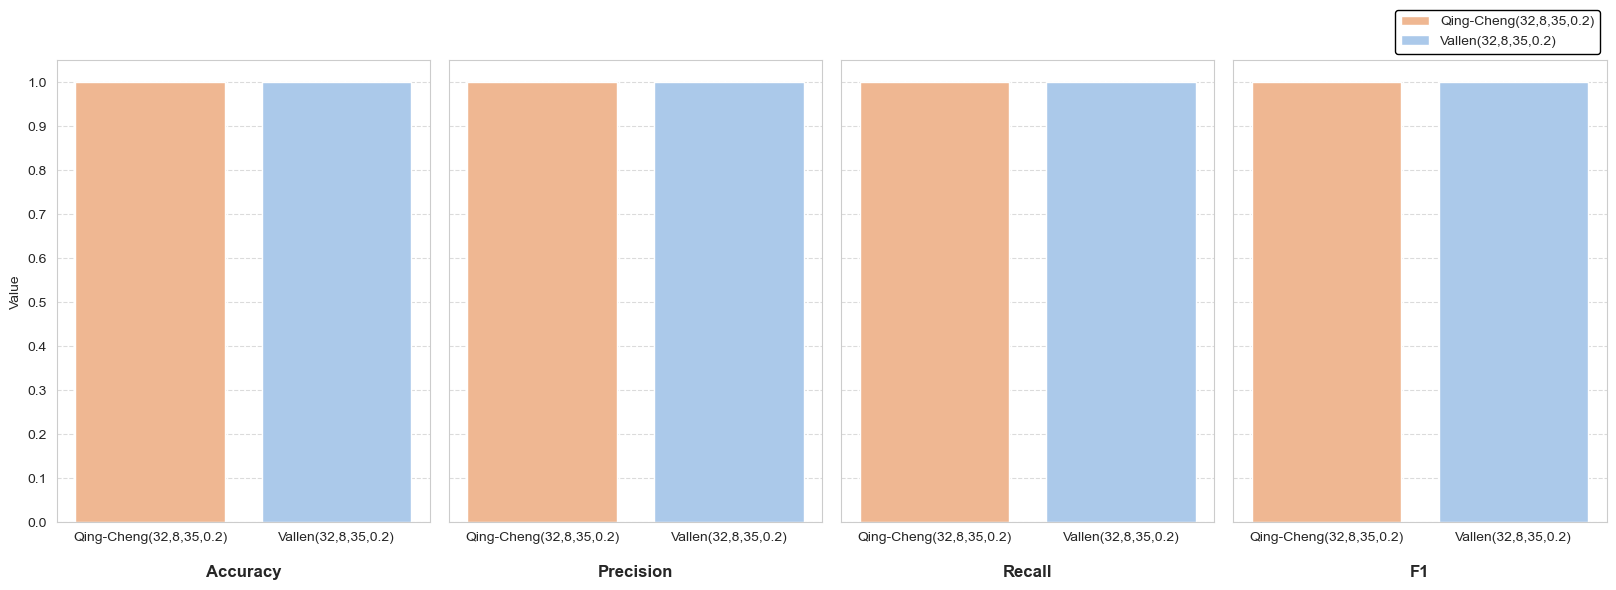

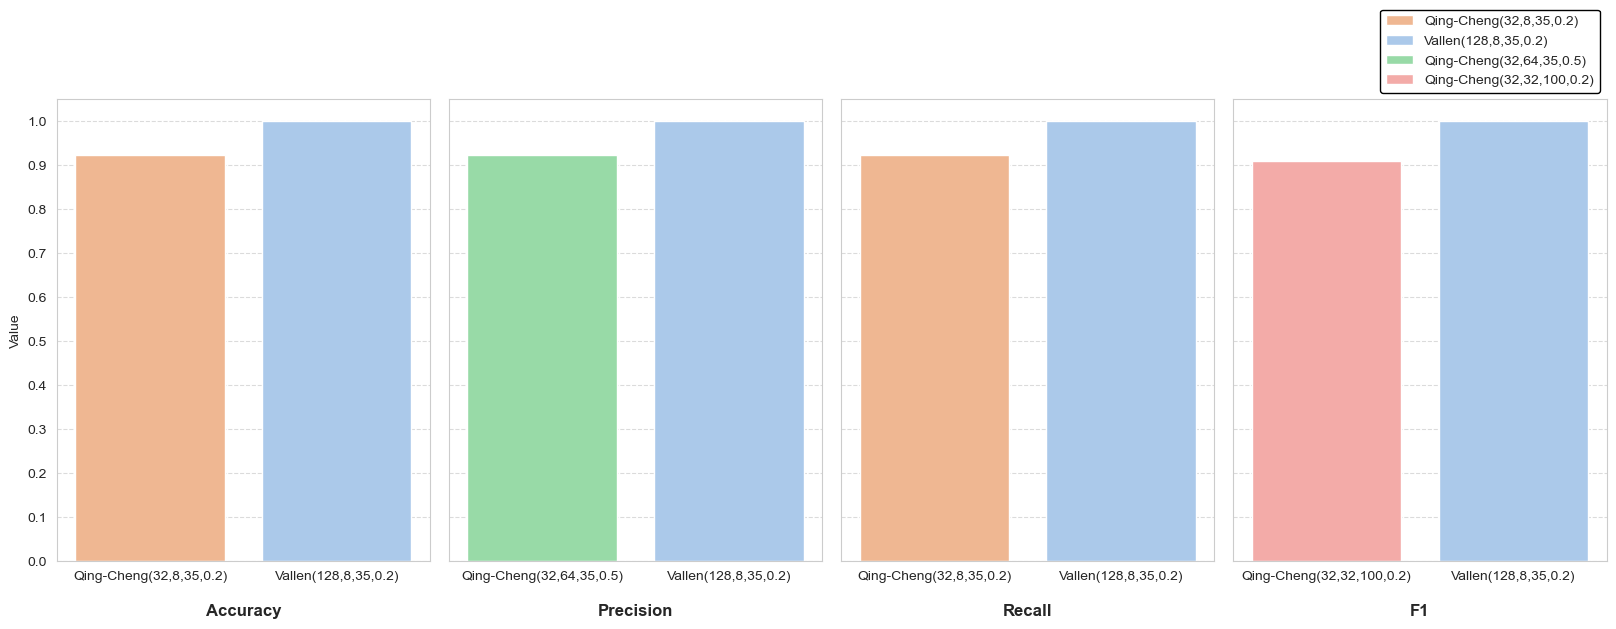

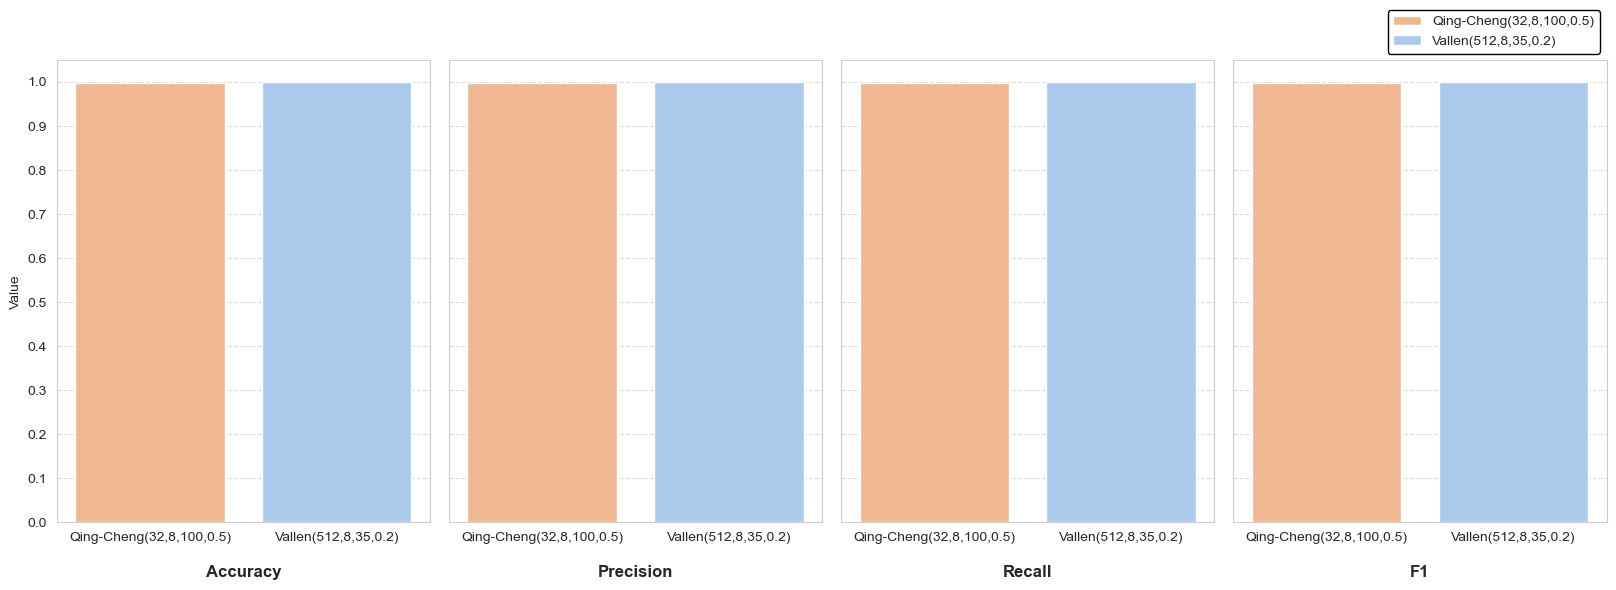

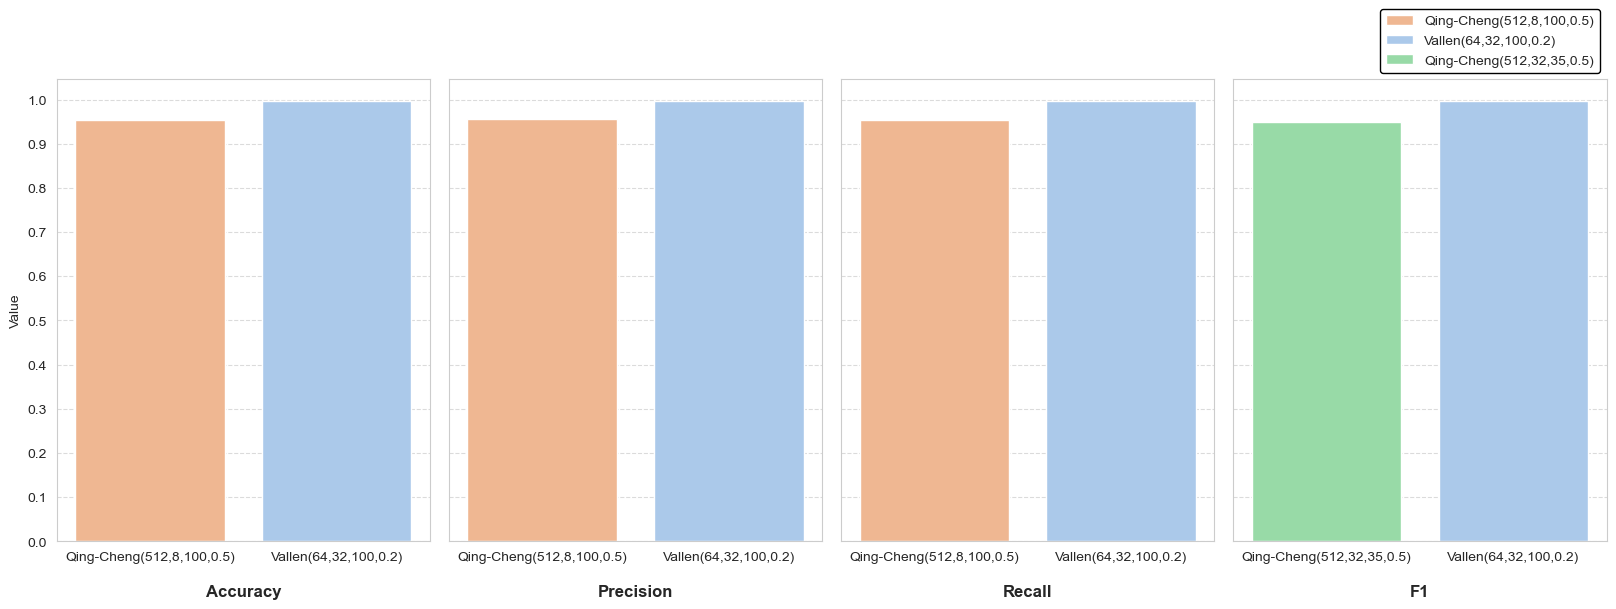

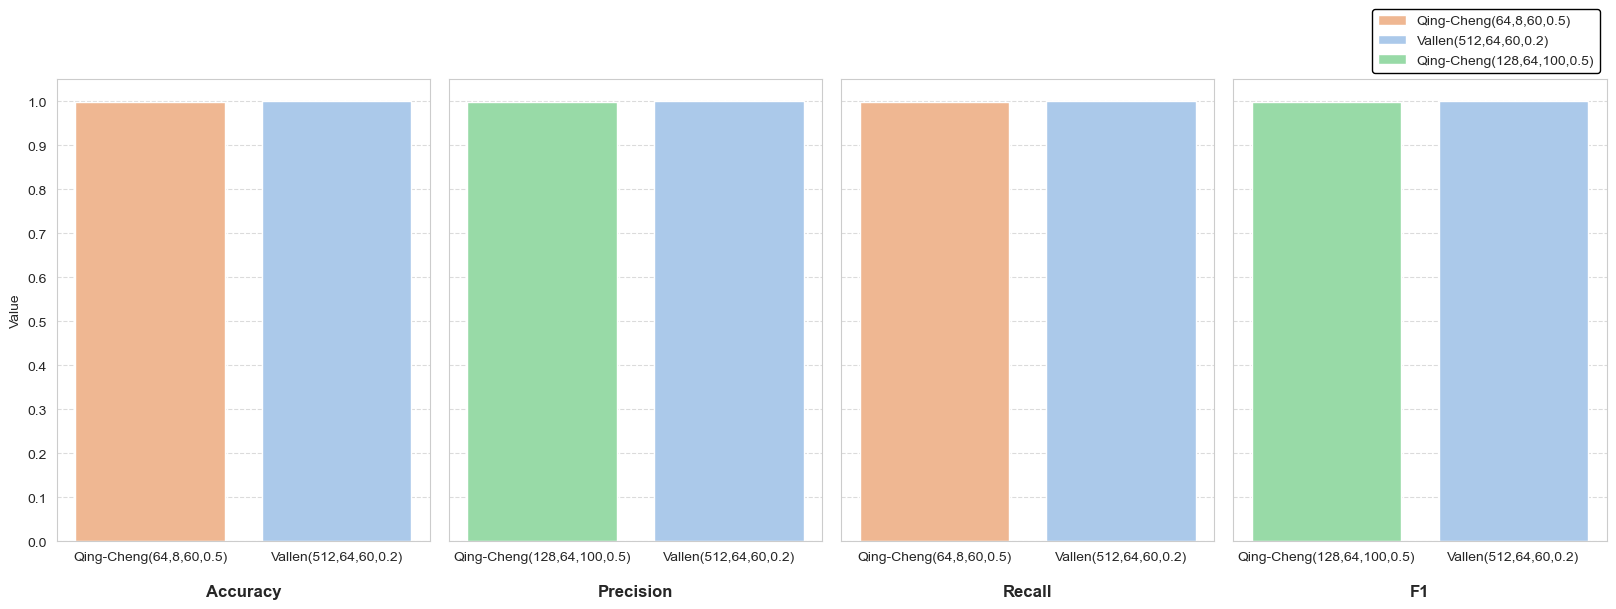

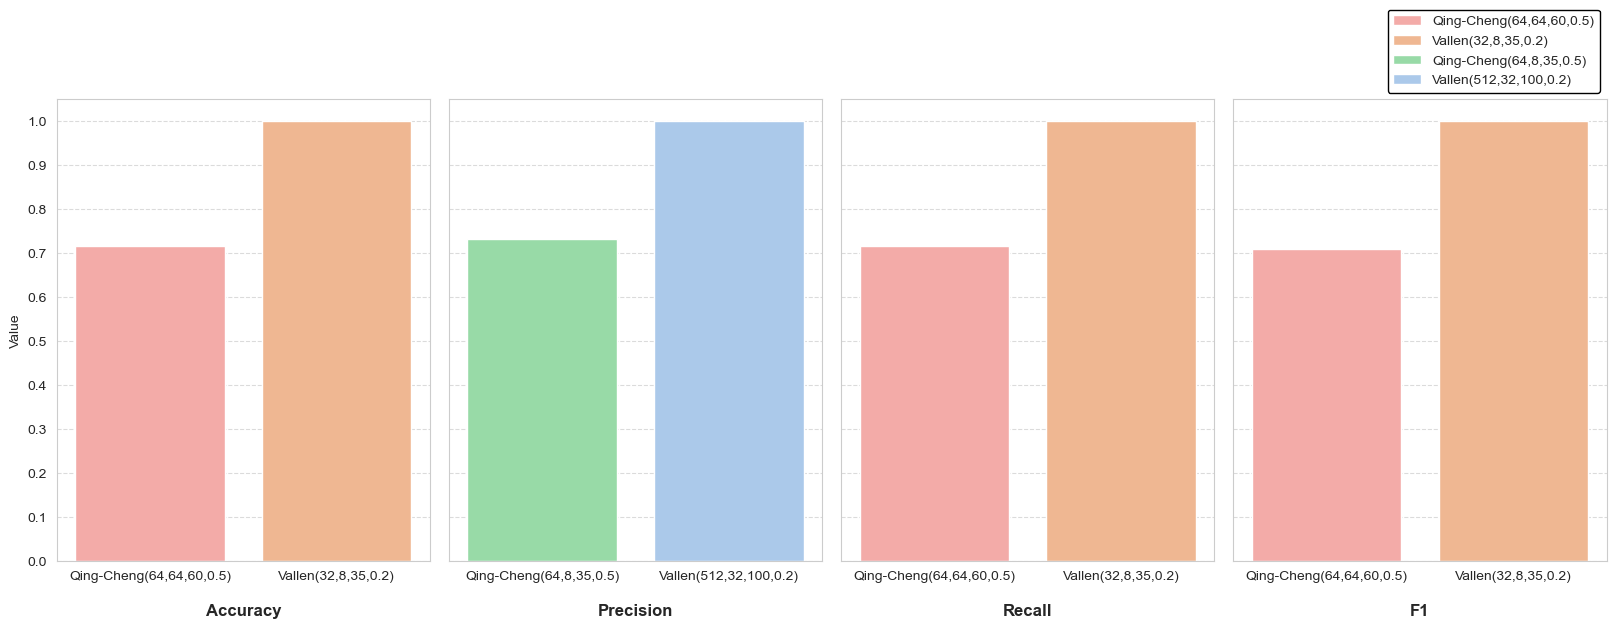

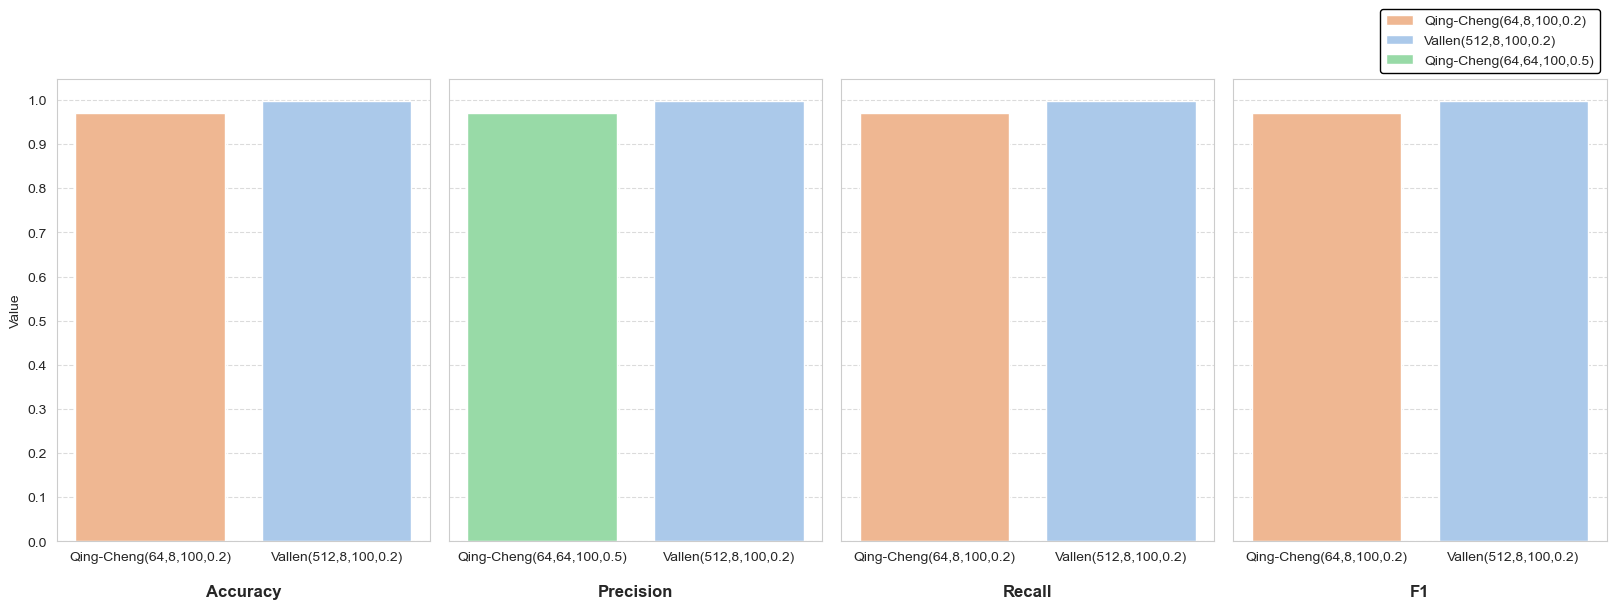

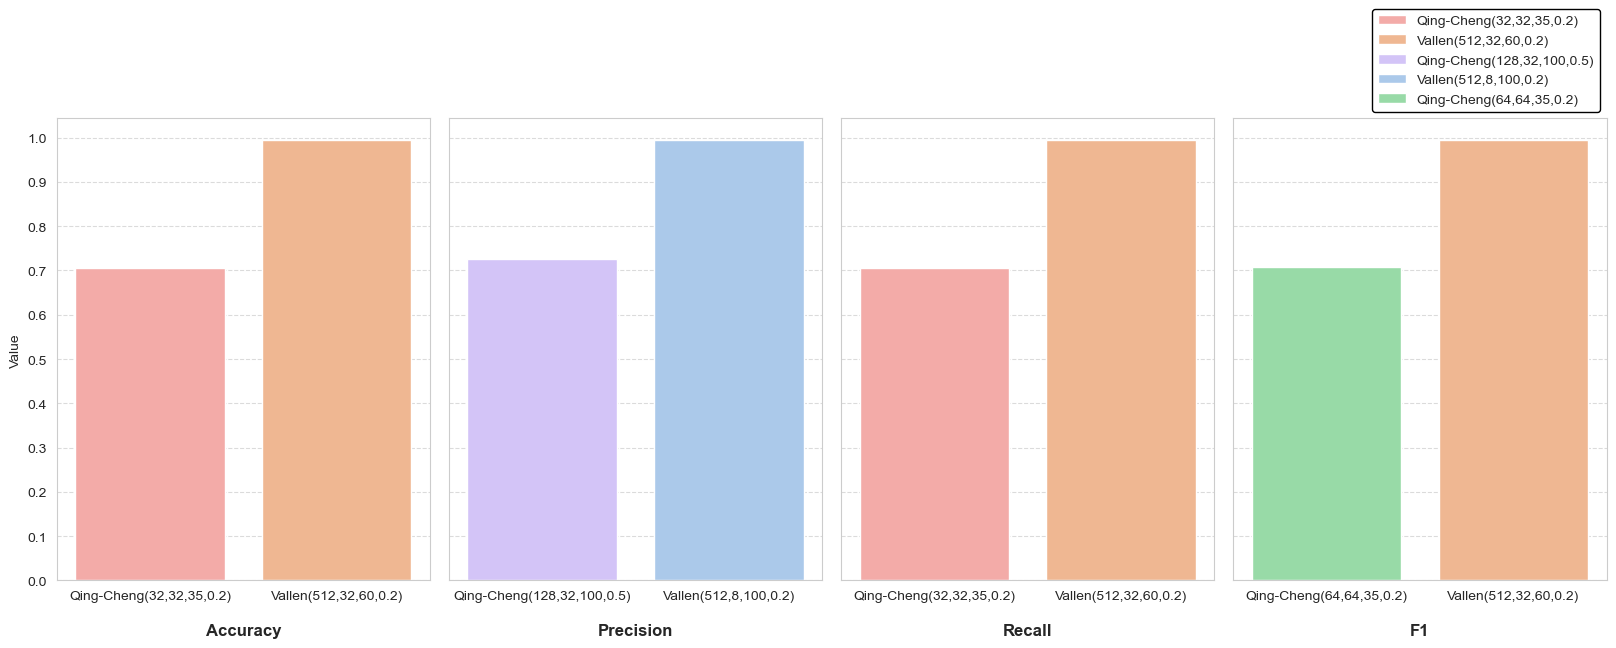

In [31]:
for index in range(len(qing_cheng_models)):
    best_models_set = set()
    
    acc_plot = pd.concat([
        qing_cheng_models[index]['all_results'].sort_values('accuracy', ascending=False).head(1), 
        vallen_models[index]['all_results'].sort_values('accuracy', ascending=False).head(1),
    ])
    
    acc_plot['metric'] = 'accuracy'
    
    best_models_set.update(acc_plot['model'].values)
    
    
    precision_plot = pd.concat([
        qing_cheng_models[index]['all_results'].sort_values('precision', ascending=False).head(1), 
        vallen_models[index]['all_results'].sort_values('precision', ascending=False).head(1),
    ])
    
    precision_plot['metric'] = 'precision'
    
    best_models_set.update(precision_plot['model'].values)
    
    
    recall_plot = pd.concat([
        qing_cheng_models[index]['all_results'].sort_values('recall', ascending=False).head(1), 
        vallen_models[index]['all_results'].sort_values('recall', ascending=False).head(1),
    ])
    
    recall_plot['metric'] = 'recall'
    
    best_models_set.update(recall_plot['model'].values)
    
    
    f1_plot = pd.concat([
        qing_cheng_models[index]['all_results'].sort_values('f1', ascending=False).head(1), 
        vallen_models[index]['all_results'].sort_values('f1', ascending=False).head(1),
    ])
    
    f1_plot['metric'] = 'f1'
    
    best_models_set.update(f1_plot['model'].values)
    
    best_models = sorted(best_models_set, reverse=True)
    color_palettes = sns.color_palette('pastel', len(best_models_set)).as_hex()
    
    color_dict = dict(zip(best_models, color_palettes))
    model_dict = dict(zip(color_palettes, best_models))
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True, gridspec_kw={'wspace': 0.05})
    
    new_handles = []
    new_labels = []
    
    labels_set = set()
    
    for i, best_model in enumerate([acc_plot, precision_plot, recall_plot, f1_plot]):
        ax = axes[i]
        
        metric = best_model['metric'].iloc[0]
        
        model_a = best_model['model'].iloc[0]
        model_b = best_model['model'].iloc[1]
        
        palette = [color_dict[model_a], color_dict[model_b]]
        
        sns.barplot(x='model', y=metric, hue=palette, data=best_model, palette=palette, ax=ax)
    
        ax.set_xlabel(metric.capitalize(), fontsize=12, labelpad=15, weight='bold')
        ax.set_ylabel('Value')
    
        # ax.legend(title='Model', bbox_to_anchor=(1, 1))
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        handles, labels = ax.get_legend_handles_labels()
        
        for handle, label in zip(handles, labels):
            if label not in labels_set:
                new_handles.append(handle)
                new_labels.append(model_dict[label])
                
                labels_set.add(label)
                
        ax.legend([], [], frameon=False)
    
    axes[3].legend(new_handles, new_labels, loc='lower right', bbox_to_anchor=(1,1), framealpha=1, edgecolor='black')
    
    plt.yticks(np.arange(0, 1.1, 0.1))
    # plt.suptitle('Comparação de Métricas entre Modelos', fontsize=14)
    plt.show()